In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import json

warnings.filterwarnings("ignore", category=UserWarning, module='seaborn')


In [2]:
# Load and inspect the dataset
df = pd.read_csv('train.csv')
df.head()


,id,Price,Area,Location,No. of Bedrooms,New/Resale,Gymnasium,Lift Available,Car Parking,Maintenance Staff,24x7 Security,Children's Play Area,Clubhouse,Intercom,Landscaped Gardens,Indoor Games,Gas Connection,Jogging Track,Swimming Pool
0,0,4850000,720,Kharghar,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0
1,1,4500000,600,Kharghar,1,0,1,1,1,1,1,0,1,0,0,0,0,1,1
2,2,6700000,650,Kharghar,1,0,1,1,1,1,1,1,1,1,0,0,0,1,1
3,3,4500000,650,Kharghar,1,0,0,1,1,1,1,0,0,1,1,0,0,0,0
4,4,5000000,665,Kharghar,1,0,0,1,1,1,1,0,0,1,1,0,0,0,0


In [3]:
# Dataset basic analysis
df.describe()
df.isnull().sum()


id                      0
Price                   0
Area                    0
Location                0
No. of Bedrooms         0
New/Resale              0
Gymnasium               0
Lift Available          0
Car Parking             0
Maintenance Staff       0
24x7 Security           0
Children's Play Area    0
Clubhouse               0
Intercom                0
Landscaped Gardens      0
Indoor Games            0
Gas Connection          0
Jogging Track           0
Swimming Pool           0
dtype: int64

In [4]:
# Check the number of unique locations
num_unique_locations = len(df["Location"].unique())
num_unique_locations


413

In [5]:
# Group locations by count and display top 50
location_counts = df.groupby("Location")['Location'].agg('count').sort_values(ascending=False)[:50]
location_counts


Location
Kharghar            533
Thane West          418
Mira Road East      390
Ulwe                319
Borivali West       176
Kalyan West         176
Nala Sopara         172
Malad West          163
Andheri West        161
Powai               141
Kandivali East      141
Panvel              136
Chembur             135
Kandivali West      115
Virar               107
Kamothe             104
Goregaon West        86
Malad East           85
Andheri East         83
Mulund West          76
Taloja               65
Goregaon East        64
Ville Parle East     63
Boisar               61
Dahisar              58
Naigaon East         55
Seawoods             44
Dombivali            44
Borivali East        43
Vasai                41
Badlapur East        40
Ghatkopar West       39
Juhu                 36
Ghansoli             33
Magathane            33
Bhandup West         32
Sanpada              32
Koproli              31
Karanjade            30
Dronagiri            29
Jogeshwari West      29
Kalwa  

In [6]:
# Mark less frequent locations as 'Other'
top_50_locations = df['Location'].value_counts().head(60).index
df['Location'] = df['Location'].apply(lambda x: x if x in top_50_locations else 'Other')
df['Location'].head()


0    Kharghar
1    Kharghar
2    Kharghar
3    Kharghar
4    Kharghar
Name: Location, dtype: object

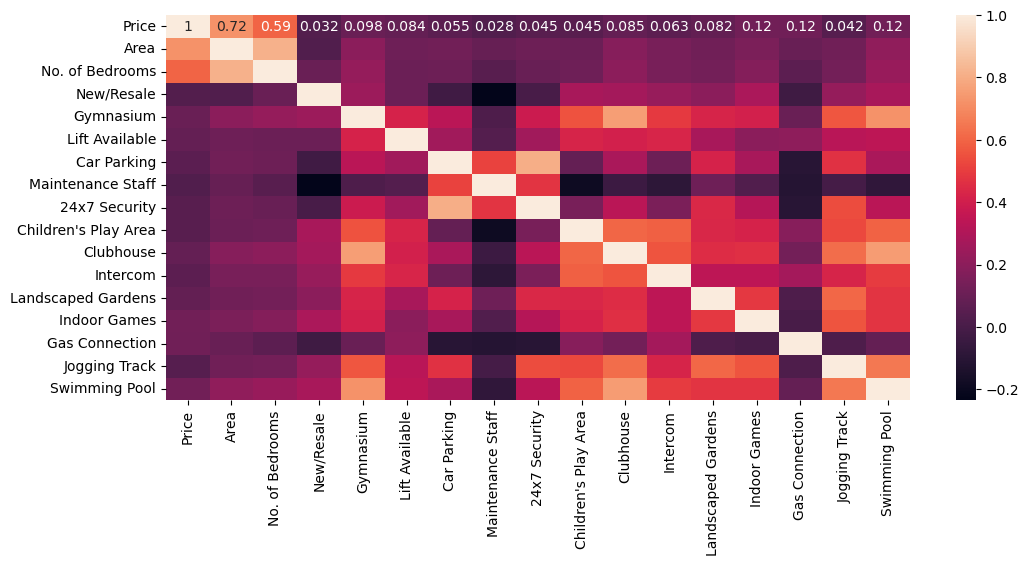

In [7]:
# Graphical Analysis - Correlation heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(df.drop(['id', 'Location'], axis=1).corr(), annot=True)
plt.show()


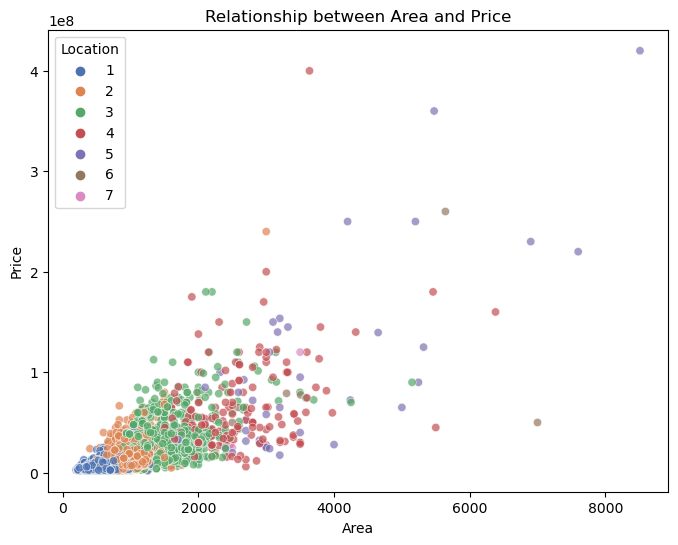

In [8]:
# Scatter plot for Area vs Price
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Area', y='Price', hue='No. of Bedrooms', palette='deep', alpha=0.7)
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Relationship between Area and Price')
plt.legend(title='Location')
plt.show()


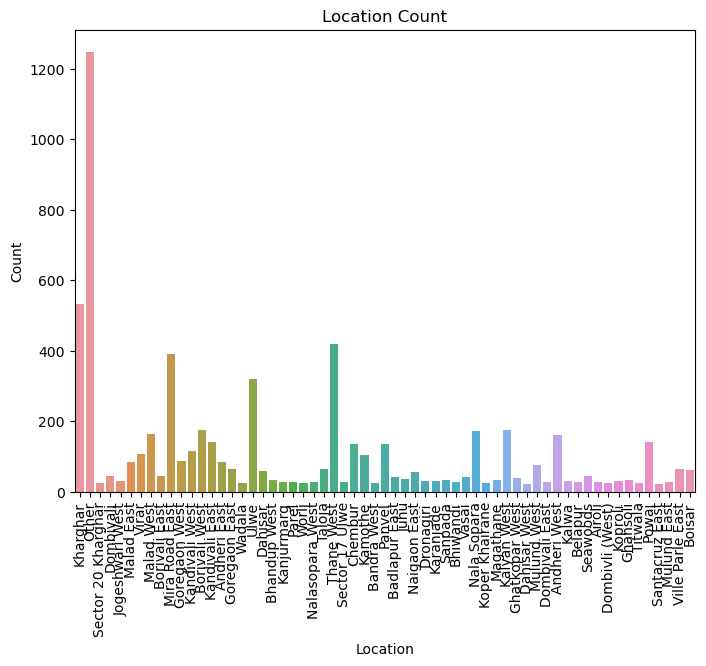

In [9]:
#Count plot for Locations
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Location')
plt.title('Location Count')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


In [10]:
#Identify outliers using IQR
Q1 = np.percentile(df['Price'], 25)
Q3 = np.percentile(df['Price'], 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Price'] < lower_bound) | (df['Price'] > upper_bound)]
outliers


,id,Price,Area,Location,No. of Bedrooms,New/Resale,Gymnasium,Lift Available,Car Parking,Maintenance Staff,24x7 Security,Children's Play Area,Clubhouse,Intercom,Landscaped Gardens,Indoor Games,Gas Connection,Jogging Track,Swimming Pool
24,24,40000000,2100,Kharghar,4,0,0,1,1,1,1,0,0,1,0,0,0,0,0
53,53,40000000,2100,Kharghar,4,0,1,1,1,1,1,1,1,1,0,0,0,0,1
187,187,65000000,1200,Other,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0
188,188,45000000,1717,Other,3,1,1,0,0,0,0,1,0,0,0,0,0,0,0
198,198,43500000,2600,Malad East,3,1,1,1,1,1,1,1,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6326,6326,39000000,1600,Malad West,3,0,1,1,0,0,0,1,1,1,1,0,0,0,1
6331,6331,39500000,940,Other,3,0,0,1,0,0,0,0,0,1,0,0,1,0,0
6332,6332,39000000,940,Other,3,0,0,1,0,0,0,0,0,0,0,0,1,0,0
6333,6333,38500000,985,Other,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [11]:
# Identify outliers using Z-score
from scipy import stats

z_scores = stats.zscore(df['Price'])
outliers = df[(z_scores > 3) | (z_scores < -3)]
outliers


,id,Price,Area,Location,No. of Bedrooms,New/Resale,Gymnasium,Lift Available,Car Parking,Maintenance Staff,24x7 Security,Children's Play Area,Clubhouse,Intercom,Landscaped Gardens,Indoor Games,Gas Connection,Jogging Track,Swimming Pool
223,223,81600000,3888,Goregaon West,4,0,1,1,1,1,1,1,1,1,1,1,0,1,1
267,267,106000000,2826,Worli,3,0,0,1,1,0,1,0,0,0,1,0,0,0,1
268,268,101400000,2880,Other,3,0,0,1,1,0,0,0,0,0,1,0,0,0,1
287,287,90000000,5245,Thane West,5,1,1,1,1,0,0,1,1,1,1,1,1,1,1
525,525,85000000,2350,Other,4,0,1,1,1,1,1,1,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,6036,120000000,3000,Other,4,0,0,1,1,0,0,1,0,0,1,0,0,0,0
6097,6097,80000000,2590,Andheri West,5,0,0,1,0,0,0,0,0,1,0,0,0,0,0
6161,6161,85000000,2100,Ville Parle East,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6202,6202,240000000,3000,Bandra West,2,1,1,1,0,0,0,1,1,1,0,0,0,0,0


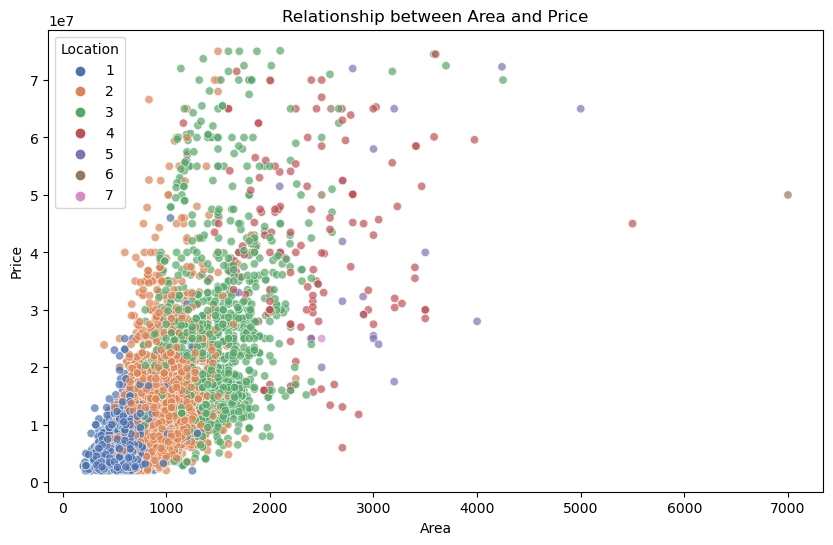

In [12]:
#Remove outliers and visualize the data again
df = df.drop(outliers.index)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Area', y='Price', hue='No. of Bedrooms', palette='deep', alpha=0.7)
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Relationship between Area and Price')
plt.legend(title='Location')
plt.show()


In [13]:
#Feature Engineering - Label Encoding
le = LabelEncoder()
df['Location'] = le.fit_transform(df['Location'])
df['Price'] = np.log(df['Price'])


In [14]:
# Train-test split
X = df.drop(['id', 'Price'], axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Save the location encoding to a JSON file
area_key = dict()
classes = le.classes_
for i, class_ in enumerate(classes):
    area_key[class_] = i

with open('area_key.json', 'w') as fp:
    json.dump(area_key, fp, indent=4)


In [16]:
# Feature selection using SelectKBest
selector = SelectKBest(score_func=f_classif, k=8)
X_new = selector.fit_transform(X_train, y_train)
selected_mask = selector.get_support()
selected_features = X_train.columns[selected_mask]
print("Selected features:", selected_features)


Selected features: Index(['Area', 'Location', 'No. of Bedrooms', 'New/Resale', 'Gymnasium',
       'Clubhouse', 'Indoor Games', 'Swimming Pool'],
      dtype='object')


In [17]:
# Drop unselected columns
drop_cols = ['Lift Available', 'Car Parking', 'Maintenance Staff', '24x7 Security',
             "Children's Play Area", 'Intercom', 'Landscaped Gardens', 
             'Gas Connection', 'Jogging Track']
X_train = X_train.drop(drop_cols, axis=1)
X_test = X_test.drop(drop_cols, axis=1)


In [18]:
# Train different regression models and predict
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predicted = lr_model.predict(X_test)

# Polynomial Regression
poly_features = PolynomialFeatures(degree=2)
poly_model = LinearRegression()
pipeline = make_pipeline(poly_features, poly_model)
pipeline.fit(X_train, y_train)
poly_predicted = pipeline.predict(X_test)

# Support Vector Regression
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)
svr_predicted = svr_model.predict(X_test)

# Decision Tree
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
dt_predicted = dt_model.predict(X_test)

# Random Forest Regressor
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_predicted = rf_model.predict(X_test)

# Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train, y_train)
gbr_predicted = gbr_model.predict(X_test)

# KNN Regression
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)
knn_predicted = knn_model.predict(X_test)


In [19]:
# Evaluate models using R2, MAE, and MSE
scores = pd.DataFrame(columns=['Linear Regression', 'Polynomial Regression', 'SVR', 
                               'Decision Tree', 'Random Forest', 'Gradient Boosting', 
                               'KNN Regressor'],
                      index=['R2', 'MAE', 'MSE'])

scores['Linear Regression'] = [
    r2_score(y_test, lr_predicted),
    mean_absolute_error(y_test, lr_predicted),
    mean_squared_error(y_test, lr_predicted)
]

scores['Polynomial Regression'] = [
    r2_score(y_test, poly_predicted),
    mean_absolute_error(y_test, poly_predicted),
    mean_squared_error(y_test, poly_predicted)
]

scores['SVR'] = [
    r2_score(y_test, svr_predicted),
    mean_absolute_error(y_test, svr_predicted),
    mean_squared_error(y_test, svr_predicted)
]

scores['Decision Tree'] = [
    r2_score(y_test, dt_predicted),
    mean_absolute_error(y_test, dt_predicted),
    mean_squared_error(y_test, dt_predicted)
]

scores['Random Forest'] = [
    r2_score(y_test, rf_predicted),
    mean_absolute_error(y_test, rf_predicted),
    mean_squared_error(y_test, rf_predicted)
]

scores['Gradient Boosting'] = [
    r2_score(y_test, gbr_predicted),
    mean_absolute_error(y_test, gbr_predicted),
    mean_squared_error(y_test, gbr_predicted)
]

scores['KNN Regressor'] = [
    r2_score(y_test, knn_predicted),
    mean_absolute_error(y_test, knn_predicted),
    mean_squared_error(y_test, knn_predicted)
]

scores


,Linear Regression,Polynomial Regression,SVR,Decision Tree,Random Forest,Gradient Boosting,KNN Regressor
R2,0.553244,0.583932,0.516515,0.736776,0.801887,0.773581,0.565056
MAE,0.430962,0.416764,0.445403,0.256047,0.234233,0.281601,0.395326
MSE,0.290178,0.270245,0.314033,0.170969,0.128679,0.147064,0.282506


In [20]:
# Save the best model (Random Forest) as a compressed pickle file
import gzip

with gzip.open('model.pkl.gz', 'wb') as f:
    pk.dump(rf_model, f)
